In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [190]:
df = pd.read_pickle('../../../cooked_data/caluire_2011_2021_monthly.pickle')
length = 12
result_mul = seasonal_decompose(df['1340'], model = 'multiplicative', period = 12)

In [191]:
def predict(df, length):
    result_mul = seasonal_decompose(df['1340'], model = 'multiplicative', period = 12)

    df['deseasonalized'] = df['1340'].values/result_mul.seasonal
    df['linearized'] = np.log(df['deseasonalized'])

    train = df['linearized']
    p, d, q = 3, 1, 2
    
    arima = ARIMA(train, order=(p,d,q)).fit()
    forecast, std_err, confidence_int = arima.forecast(length, alpha=0.05)
    forecast = np.exp(forecast)*result_mul.seasonal[-length:]
    train = np.exp(train)*result_mul.seasonal
    lower = np.exp(confidence_int)[:,0]*result_mul.seasonal[-length:]
    upper = np.exp(confidence_int)[:,1]*result_mul.seasonal[-length:]
    return train, forecast, std_err, confidence_int

#forecast_recons = np.exp(forecast)*result_mul.seasonal[-length:]
#train_recons = np.exp(train)*result_mul.seasonal
#lower_recons = np.exp(confidence_int)[:,0]*result_mul.seasonal[-length:]
#upper_recons = np.exp(confidence_int)[:,1]*result_mul.seasonal[-length:]

In [192]:
predict(df, length)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96652D-02    |proj g|=  7.27421D+00

At iterate    5    f= -7.54698D-02    |proj g|=  8.88865D-02

At iterate   10    f= -7.56910D-02    |proj g|=  1.23953D+00

At iterate   15    f= -7.64437D-02    |proj g|=  2.52713D-03

At iterate   20    f= -7.64943D-02    |proj g|=  4.29437D-03

At iterate   25    f= -7.65315D-02    |proj g|=  1.36074D-01

At iterate   30    f= -7.65571D-02    |proj g|=  3.83087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


(date
 2011-11-01    11.1
 2011-12-01    11.1
 2012-01-01    13.0
 2012-02-01    13.0
 2012-03-01    10.6
               ... 
 2021-04-01    10.5
 2021-05-01     9.1
 2021-06-01     8.9
 2021-07-01     7.9
 2021-08-01     8.7
 Freq: MS, Length: 118, dtype: float64,
 date
 2020-09-01     6.555290
 2020-10-01     7.890158
 2020-11-01    10.635301
 2020-12-01    12.371106
 2021-01-01    13.070258
 2021-02-01    11.225696
 2021-03-01    10.797518
 2021-04-01     9.395075
 2021-05-01     8.563721
 2021-06-01     7.837704
 2021-07-01     6.202321
 2021-08-01     4.640282
 Freq: MS, Name: seasonal, dtype: float64,
 array([0.2191104 , 0.26381495, 0.27261787, 0.27866029, 0.27930289,
        0.28043574, 0.2804452 , 0.2807398 , 0.28075372, 0.28086241,
        0.28089035, 0.28094337]),
 array([[2.08967969, 2.94857669],
        [1.83758477, 2.87172038],
        [1.74602221, 2.81466464],
        [1.66804381, 2.76037208],
        [1.64681894, 2.74166613],
        [1.6145393 , 2.71382721],
        [1.

In [193]:
forecast = predict(df, length)[1]
train = predict(df, length)[0]
upper = predict(df, length)[3][:,0]
lower = predict(df, length)[3][:,1]
confidence_int = predict(df, length)[3]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96652D-02    |proj g|=  7.27421D+00

At iterate    5    f= -7.54698D-02    |proj g|=  8.88865D-02

At iterate   10    f= -7.56910D-02    |proj g|=  1.23953D+00

At iterate   15    f= -7.64437D-02    |proj g|=  2.52713D-03

At iterate   20    f= -7.64943D-02    |proj g|=  4.29437D-03

At iterate   25    f= -7.65315D-02    |proj g|=  1.36074D-01

At iterate   30    f= -7.65571D-02    |proj g|=  3.83087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96652D-02    |proj g|=  7.27421D+00

At iterate    5    f= -7.54698D-02    |proj g|=  8.88865D-02

At iterate   10    f= -7.56910D-02    |proj g|=  1.23953D+00

At iterate   15    f= -7.64437D-02    |proj g|=  2.52713D-03

At iterate   20    f= -7.64943D-02    |proj g|=  4.29437D-03

At iterate   25    f= -7.65315D-02    |proj g|=  1.36074D-01

At iterate   30    f= -7.65571D-02    |proj g|=  3.83087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96652D-02    |proj g|=  7.27421D+00

At iterate    5    f= -7.54698D-02    |proj g|=  8.88865D-02

At iterate   10    f= -7.56910D-02    |proj g|=  1.23953D+00

At iterate   15    f= -7.64437D-02    |proj g|=  2.52713D-03

At iterate   20    f= -7.64943D-02    |proj g|=  4.29437D-03

At iterate   25    f= -7.65315D-02    |proj g|=  1.36074D-01

At iterate   30    f= -7.65571D-02    |proj g|=  3.83087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96652D-02    |proj g|=  7.27421D+00

At iterate    5    f= -7.54698D-02    |proj g|=  8.88865D-02

At iterate   10    f= -7.56910D-02    |proj g|=  1.23953D+00

At iterate   15    f= -7.64437D-02    |proj g|=  2.52713D-03

At iterate   20    f= -7.64943D-02    |proj g|=  4.29437D-03

At iterate   25    f= -7.65315D-02    |proj g|=  1.36074D-01

At iterate   30    f= -7.65571D-02    |proj g|=  3.83087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96652D-02    |proj g|=  7.27421D+00

At iterate    5    f= -7.54698D-02    |proj g|=  8.88865D-02

At iterate   10    f= -7.56910D-02    |proj g|=  1.23953D+00

At iterate   15    f= -7.64437D-02    |proj g|=  2.52713D-03

At iterate   20    f= -7.64943D-02    |proj g|=  4.29437D-03

At iterate   25    f= -7.65315D-02    |proj g|=  1.36074D-01

At iterate   30    f= -7.65571D-02    |proj g|=  3.83087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


In [194]:
def plot_forecast(fc, train, upper=None, lower=None):
    index = train.index[-length:] + train.index.freq*length
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=index)
    lower_series = pd.Series(upper, index=index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

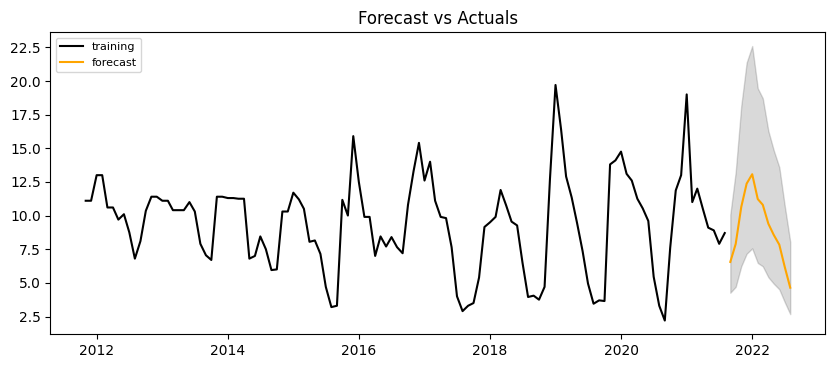

In [195]:
plot_forecast(forecast_recons.values, train_recons, lower_recons.values, upper_recons.values)